In [1]:
import sys
import os

# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

import warnings
warnings.filterwarnings('ignore')


import deeppy as dp

import torch
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import numpy as np
import matplotlib.pyplot as plt



from deeppy import LearnFrame,LayerGenerator,FromLoader
from deeppy.models.nlp.gpt import GPT
from deeppy import FromLoader


In [2]:
import pickle
from torch.utils.data import Dataset,DataLoader
class SortDataset(Dataset):
    """ 
    Dataset for the Sort problem. E.g. for problem length 6:
    Input: 0 0 2 1 0 1 -> Output: 0 0 0 1 1 2
    Which will feed into the transformer concatenated as:
    input:  0 0 2 1 0 1 0 0 0 1 1
    output: I I I I I 0 0 0 1 1 2
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=6, num_digits=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.num_digits = num_digits
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.num_digits
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * 2 - 1

    def __getitem__(self, idx):
        
        # use rejection sampling to generate an input example from the desired split
        while True:
            # generate some random integers
            inp = torch.randint(self.num_digits, size=(self.length,), dtype=torch.long)
            # half of the time let's try to boost the number of examples that 
            # have a large number of repeats, as this is what the model seems to struggle
            # with later in training, and they are kind of rate
            if torch.rand(1).item() < 0.5:
                if inp.unique().nelement() > self.length // 2:
                    # too many unqiue digits, re-sample
                    continue
            # figure out if this generated example is train or test based on its hash
            h = hash(pickle.dumps(inp.tolist()))
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        # solve the task: i.e. sort
        sol = torch.sort(inp)[0]

        # concatenate the problem specification and the solution
        cat = torch.cat((inp, sol), dim=0)

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:self.length-1] = -1
        return x, y


train_dataset = SortDataset('train')
test_dataset = SortDataset('test')
train_loader = DataLoader(
            train_dataset,
            sampler=torch.utils.data.RandomSampler(train_dataset, replacement=True, num_samples=int(1e10)),
            shuffle=False,
            pin_memory=True,
            batch_size=64,
        )

test_loader = DataLoader(
            test_dataset,
            sampler=torch.utils.data.RandomSampler(test_dataset, replacement=True, num_samples=int(1e10)),
            shuffle=False,
            pin_memory=True,
            batch_size=64,
        )

data = FromLoader(train_loader = train_loader, test_loader = test_loader)

In [3]:
Scheduler_params = {
    "scheduler" : optim.lr_scheduler.StepLR,
    "gamma":(1e-5 / 5e-4)**(1/10000),
    "auto_step":True,
    "step_size" : 1
}

Scheduler_params = {
    "scheduler" : optim.lr_scheduler.CyclicLR,
    "max_lr":5e-4,
    "base_lr":1e-5,
    "step_size_up":2000,
    "auto_step":False,
    "mode":"triangular2"
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":5e-4, "amsgrad" : True, "weight_decay" : 0, "betas" : (0.9, 0.95)},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 1.0},
    "scheduler_params":None,
}

model = GPT(optimizer_params=Optimizer_params, device=device, criterion = nn.CrossEntropyLoss(ignore_index = -1))


In [4]:
lf = LearnFrame(model,data)

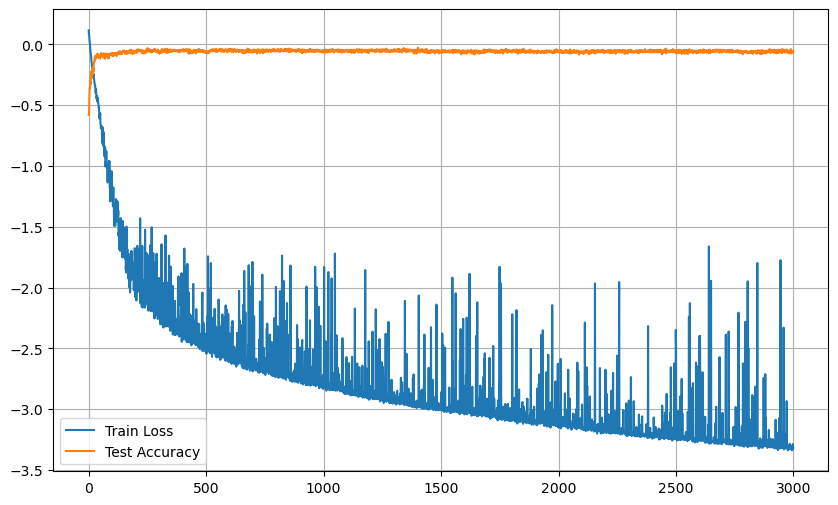

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
epoch = 2900

for i in range(epoch):
    lf.optimize()
    lf.test()
        
lf.plot(show_result=True, log=True)